# Homework 3

In [1]:
import numpy as np
import cloudpickle

import torch
import torch.nn as nn
from torch.optim.adamw import AdamW
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from os import makedirs
makedirs('hw3_models', exist_ok=True)

# Use a GPU if possible
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
    
device

device(type='mps')

First, we load the data. Requires `hw3_data.ipynb` to be run beforehand. Note that I modified this notebook to save the final data to some local files.

In [2]:
with open('hw3_data/train_labels.pkl', 'rb') as f:
    train_labels = cloudpickle.load(f)
with open('hw3_data/val_labels.pkl', 'rb') as f:
    valid_labels = cloudpickle.load(f)
with open('hw3_data/test_labels.pkl', 'rb') as f:
    test_labels = cloudpickle.load(f)

# save features as .npy files
train_features = np.load('hw3_data/train_features.npy')
valid_features = np.load('hw3_data/val_features.npy')
test_features = np.load('hw3_data/test_features.npy')

## Problem 1

> Train some kind of reasonable MLP to predict (say) the label LOGG from the spectral features. Then find a different MLP architecture that does better in terms of validation score. Do some exploring in the architecture (and maybe other choices) to find it; don’t try to be exhaustive. What architecture does best on your validation data? Does the network that does best on your validation data also do the best on the test data?

In [3]:
# note that labels need to be converted to the native byte ordering with '=f4' in order to play nice with pytorch
X_tr = torch.tensor(train_features).to(torch.float32).to(device)
Y_tr = torch.tensor(train_labels['LOGG'].astype('=f4')).to(torch.float32).to(device)
X_va = torch.tensor(valid_features).to(torch.float32).to(device)
Y_va = torch.tensor(valid_labels['LOGG'].astype('=f4')).to(torch.float32).to(device)

m = train_features.shape[1]  # number of features

In [4]:
def make_mlp(layer_sizes, activation=nn.ReLU):
    if len(layer_sizes) < 2:
        raise ValueError('layer_sizes must be at least length 2')

    layers = []
    for i in range(len(layer_sizes) - 1):
        layers.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))
        if i != len(layer_sizes) - 2:
            layers.append(activation())
        
    return nn.Sequential(*layers)


def train_mlp(layer_sizes, activation=nn.ReLU, lr=1e-4, weight_decay=0.01, n_epochs=2_000):
    net = make_mlp(layer_sizes, activation).to(device)
    opt = AdamW(net.parameters(), lr=lr, weight_decay=weight_decay)
    sched = torch.optim.lr_scheduler.StepLR(opt, 750, gamma=0.5)
    loss_fn = nn.MSELoss()

    history = {
        'loss_tr': [],
        'loss_va': [],
        'lr': []
    }

    for i in tqdm(range(n_epochs)):
        net.train()
        opt.zero_grad()
        Y_hat = net(X_tr).squeeze()
        loss = loss_fn(Y_hat, Y_tr)
        history['loss_tr'].append(loss.detach().cpu().item())
        loss.backward()
        opt.step()

        net.eval()
        Y_hat = net(X_va).squeeze()
        loss = loss_fn(Y_hat, Y_va)
        history['loss_va'].append(loss.detach().cpu().item())
        history['lr'].append(opt.param_groups[0]['lr'])
        sched.step()

    return net, history


def plot_history(history, title=""):
    fig, axs = plt.subplots(2, 1, figsize=(7, 5), sharex=True)

    axs[0].plot(history['loss_tr'], label='Train')
    axs[0].plot(history['loss_va'], label='Validation')
    axs[0].set_ylabel('MSE')
    axs[0].set_yscale('log')
    axs[0].grid(ls=':')
    axs[0].legend(loc='upper right')
    axs[0].set_title(title)
    
    axs[1].plot(history['lr'])
    axs[1].set_ylabel('Learning rate')
    axs[1].set_yscale('log')
    axs[1].grid(ls=':')
    
    axs[-1].set_xlabel('Number of epochs trained')

    fig.tight_layout()
    plt.show()

For my experimentation, I'm just going to add hidden layers of size 512 until the validation loss starts coming back up.

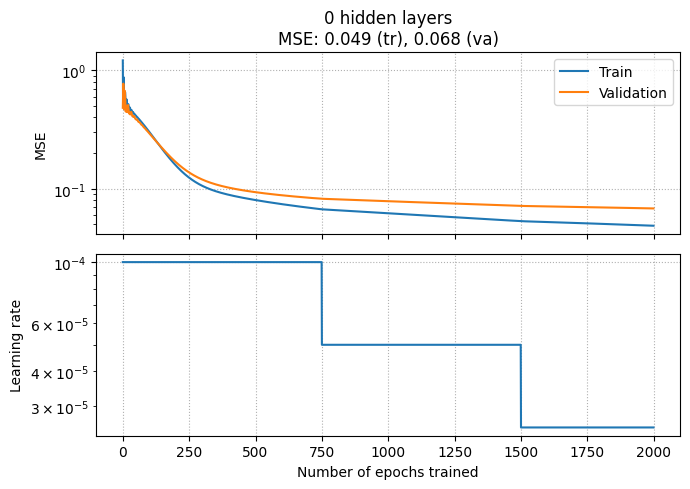

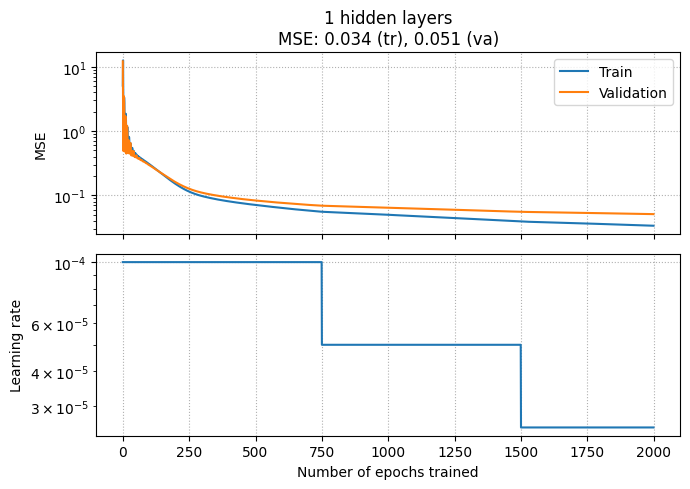

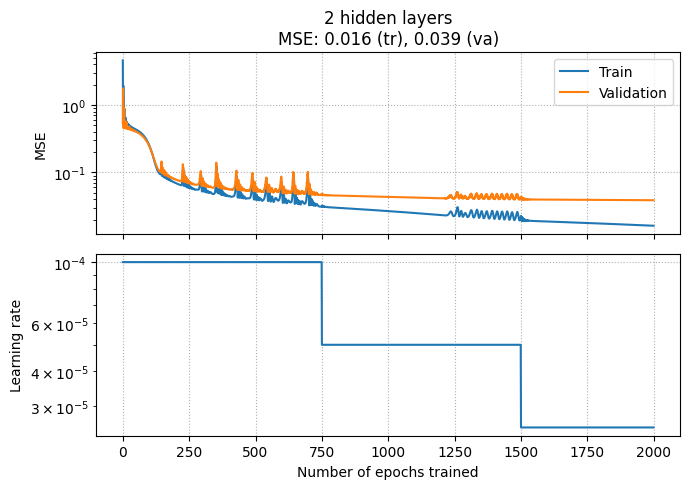

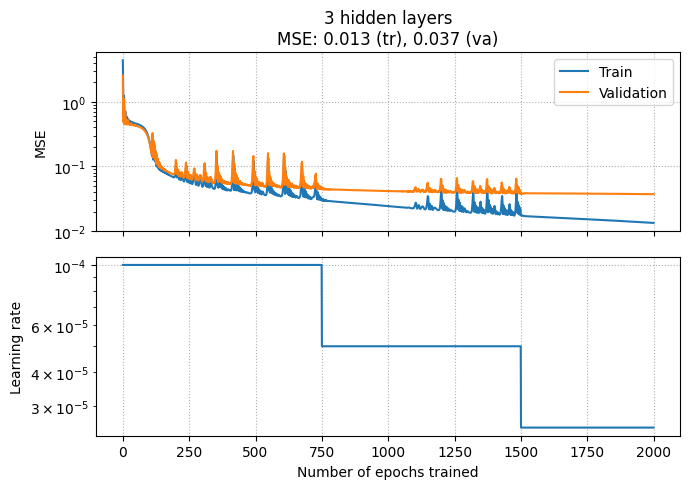

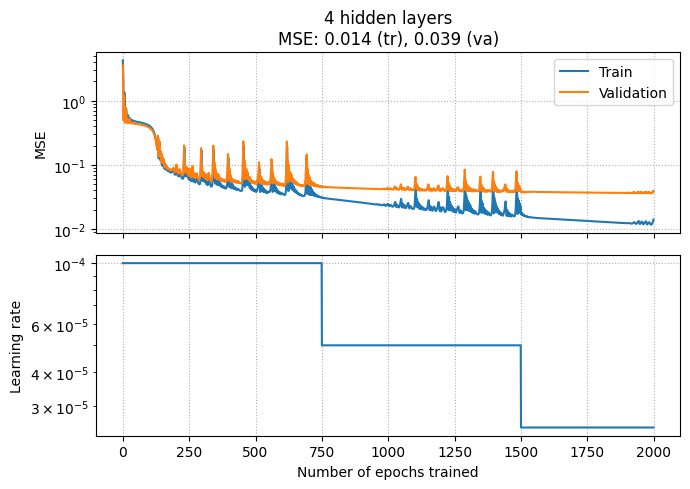

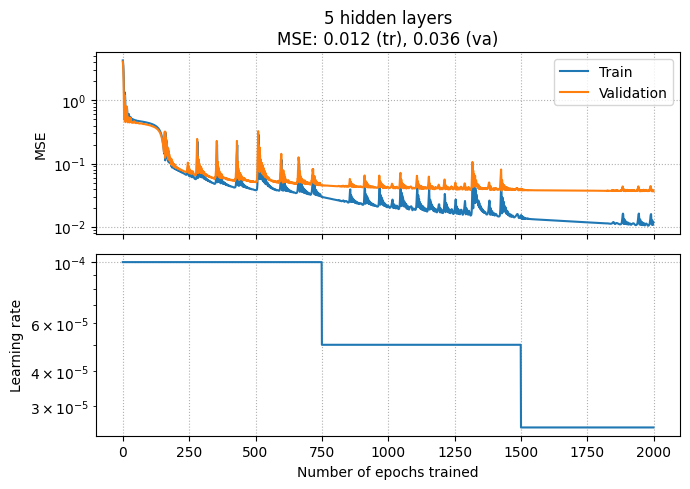

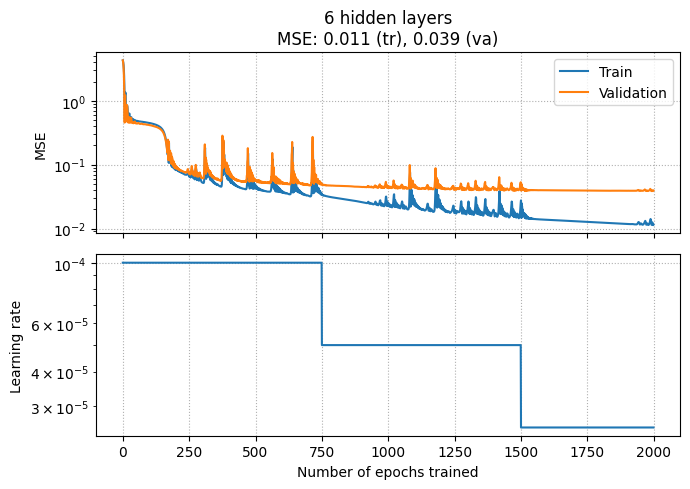

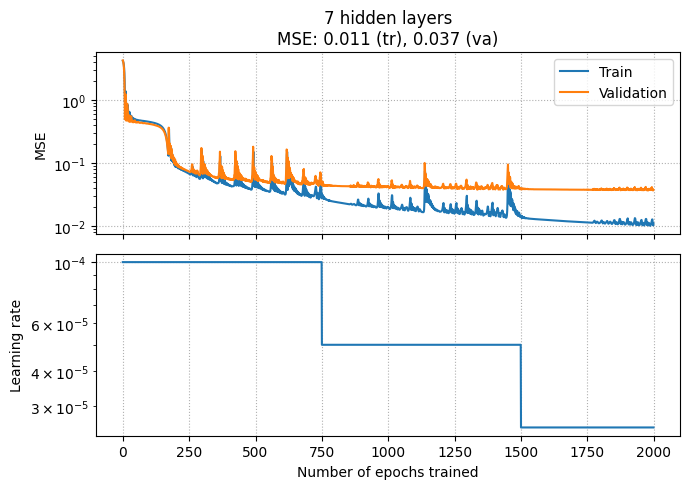

In [5]:
torch.manual_seed(1126)


nets = []
train_loss = []
val_loss = []

for i in range(8):
    
    filename = f"hw3_models/mlp_{i:02d}.pt"
    
    layer_sizes = [m] + [1024] * i + [1]
    
    try:
        # check if we've already trained this network
        state_dict = torch.load(filename)
        net = make_mlp(layer_sizes).to(device)
        net.load_state_dict(state_dict)
        history = np.load(filename.replace('.pt', '_history.npz'))
    except OSError:
        # make and train the network ourselves
        net, history = train_mlp([m] + [1024] * i + [1])
        torch.save(net.state_dict(), filename)
        np.savez(
            filename.replace('.pt', '_history.npz'),
            loss_tr=history['loss_tr'],
            loss_va=history['loss_va'],
            lr=history['lr']
        )

    plot_history(
        history,
        title=(
            f"{i} hidden layers\n" +
            f"MSE: {history['loss_tr'][-1]:.3f} (tr), " +
            f"{history['loss_va'][-1]:.3f} (va)"
        )
    )
    
    net.eval()
    nets.append(net)
    train_loss.append(history['loss_tr'][-1])
    val_loss.append(history['loss_va'][-1])

How do these perform on the test set?

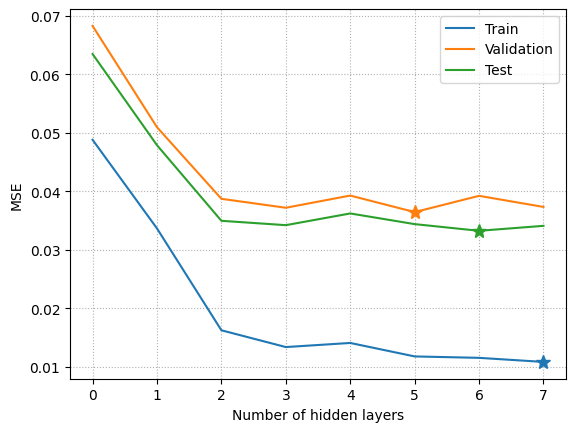

In [6]:
for net in nets:
    net.eval()

X_te = torch.tensor(test_features).to(torch.float32).to(device)
Y_te = torch.tensor(test_labels['LOGG'].astype('=f4')).to(torch.float32).to(device)

test_loss = [nn.MSELoss()(net(X_te).squeeze(), Y_te).detach().cpu().item() for net in nets]

for i, (loss, label) in enumerate(zip([train_loss, val_loss, test_loss], ['Train', 'Validation', 'Test'])):
    xs = np.arange(len(loss))
    plt.plot(xs, loss, label=label, c=f"C{i}")
    idx = np.argmin(loss)
    plt.plot(xs[idx], loss[idx], c=f"C{i}", marker="*", markersize=10)
plt.xlabel('Number of hidden layers')
plt.ylabel('MSE')
plt.legend()
plt.grid(ls=':')
plt.show()

The best performance on the validation and test sets happen on similar models: 5/6 hidden layers. They don't happen with exactly the same model, though, which is perhaps an indicator that the variation we see from 3 hidden layers on up is more variation due to the random initialization than anything else. The train set, however, sees small improvements in final MSE as the number of hidden layers continues to increase, indicating that there is likely some overfitting. The overfitting appears to be really rather gentle, though; perhaps this is because I used weight decay?

## Problem 2

> Plot the label differences between your test-set predicted labels (for your best model) and the “true” labels as a function of the other two labels (so if you are predicting LOGG, plot the differences as a function of TEFF and FE_H). Do you conclude anything from this test? Also visualize the spectrum (the features) for the worst-predicted test-set object. Anything seem weird?

For my best model, I choose the 4 hidden layer architecture, since it achieved the best performance on the validation set (and I probably shouldn't use the test set to make this decision, even though it does agree).

The worst point (point #333) has a residual of -1.11.


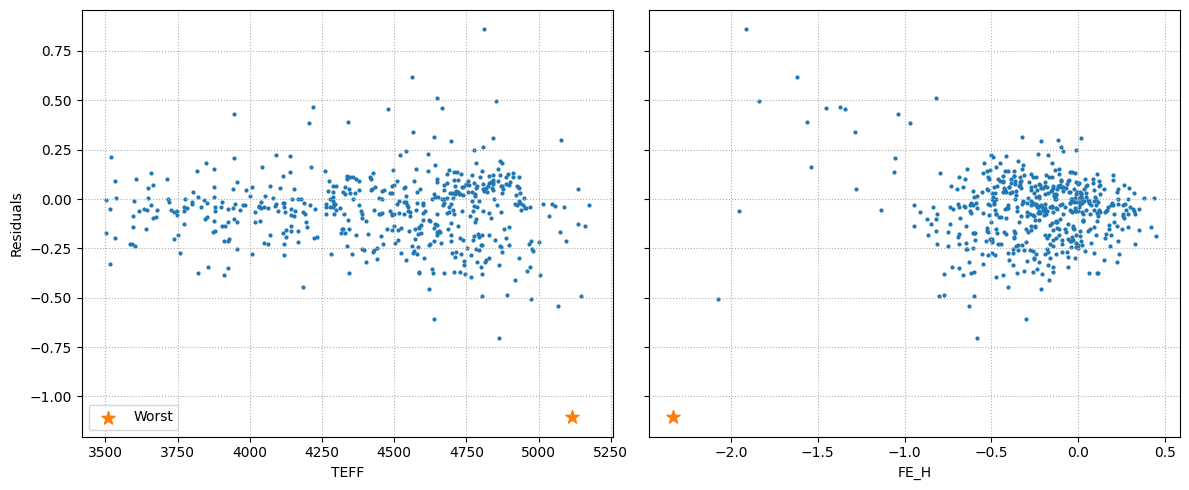

In [7]:
best_net = nets[4]
resid = (best_net(X_te).squeeze() - Y_te).detach().cpu().numpy()
worst_point = np.argmax(np.abs(resid))

print(f"The worst point (point #{worst_point}) has a residual of {resid[worst_point]:.2f}.")

teff = test_labels['TEFF']
fe_h = test_labels['FE_H']

fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
kw = dict(s=4, label='_')
worst_kw = dict(s=100, marker='*', label='Worst')
axs[0].scatter(teff, resid, **kw)
axs[0].scatter(teff[worst_point], resid[worst_point], **worst_kw)
axs[0].set_xlabel("TEFF")
axs[0].set_ylabel("Residuals")
axs[0].grid(ls=':')
axs[0].legend(loc='lower left')

axs[1].scatter(fe_h, resid, **kw)
axs[1].scatter(fe_h[worst_point], resid[worst_point], **worst_kw)
axs[1].set_xlabel("FE_H")
axs[1].grid(ls=':')

fig.tight_layout()
plt.show()

It is interesting that the worst point is at an extreme in both `TEFF` and `FE_H`. In general, it seems the worst performing points (those with residuals of abs value > 0.5) fall at the upper end of `TEFF` and the lower end of `FE_H`.

Lets look at the spectrum of the worst point and compare it to a few random points with residual of abs value < 0.3.

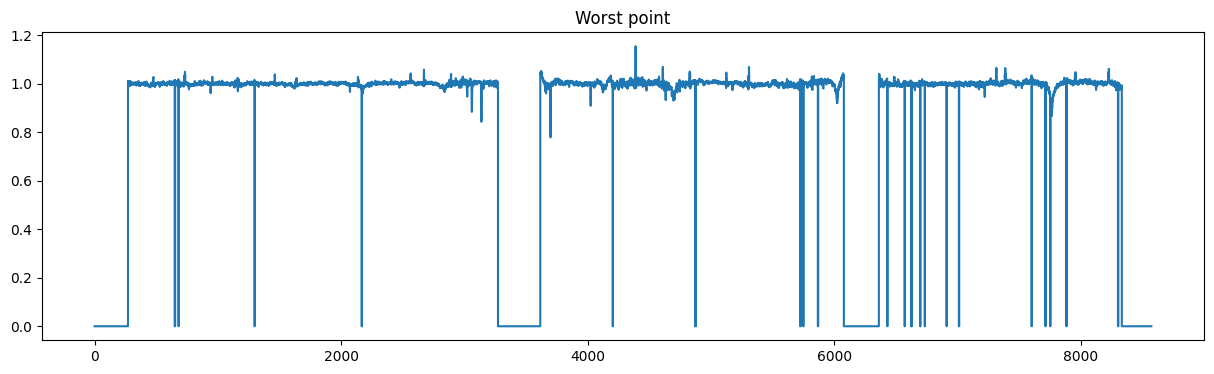

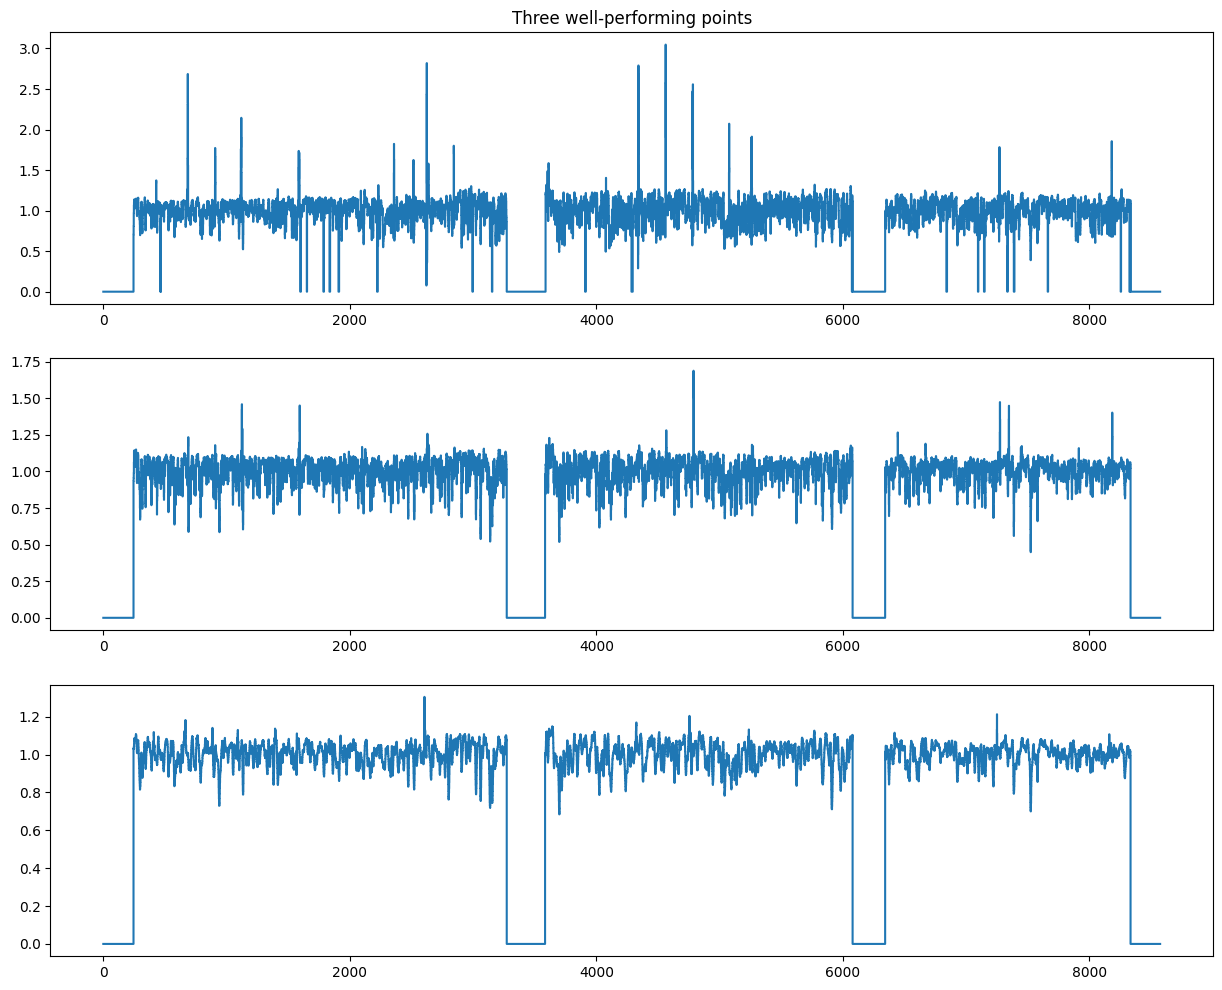

In [8]:
worst_features = X_te.cpu()[worst_point]
plt.figure(figsize=(15, 4))
plt.step(np.arange(len(worst_features)), worst_features) #, s=1)
plt.title('Worst point')
plt.show()

rng = np.random.default_rng(0)
idx = rng.choice(np.arange(len(resid))[resid < 0.3], size=(3,))

fig, axs = plt.subplots(len(idx), 1, figsize=(15, 4 * len(idx)))
for i, ax in zip(idx, axs.flat):
    feats = X_te.cpu()[i]
    ax.step(np.arange(len(feats)), feats)
axs[0].set_title('Three well-performing points')
plt.show()

These plots reveal that the worst point clearly has a different spectrum. When nonzero, it has much less variation about 1.0 than the others (the 'normal' points), and it appears to have a few more zeros.

## Problem 3

> Same as problem 1, but use a one-dimensional CNN. All the same things. In the end, what is better or worse about your CNN relative to your MLP? Also repeat problem 2 for this case.

Sequential(
  (0): Conv1d(1, 4, kernel_size=(3,), stride=(1,), padding=same, padding_mode=circular)
  (1): ReLU()
  (2): Flatten(start_dim=1, end_dim=-1)
  (3): Linear(in_features=34300, out_features=1, bias=True)
)


  0%|          | 0/2000 [00:00<?, ?it/s]

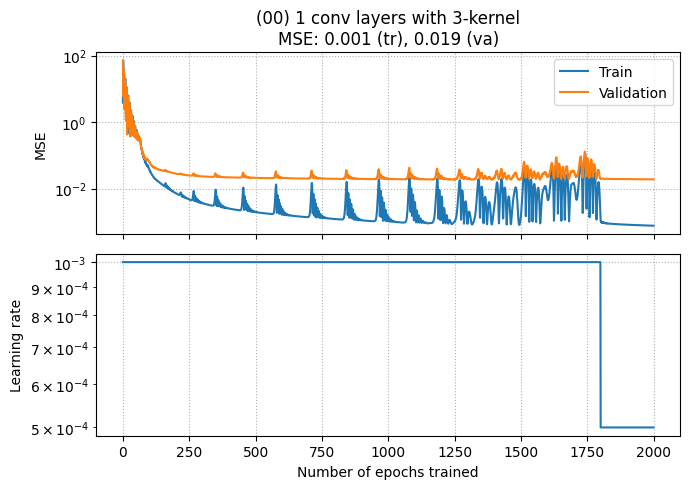

Sequential(
  (0): Conv1d(1, 4, kernel_size=(3,), stride=(1,), padding=same, padding_mode=circular)
  (1): ReLU()
  (2): Conv1d(4, 4, kernel_size=(3,), stride=(1,), padding=same, padding_mode=circular)
  (3): ReLU()
  (4): Flatten(start_dim=1, end_dim=-1)
  (5): Linear(in_features=34300, out_features=1, bias=True)
)


  0%|          | 0/2000 [00:00<?, ?it/s]

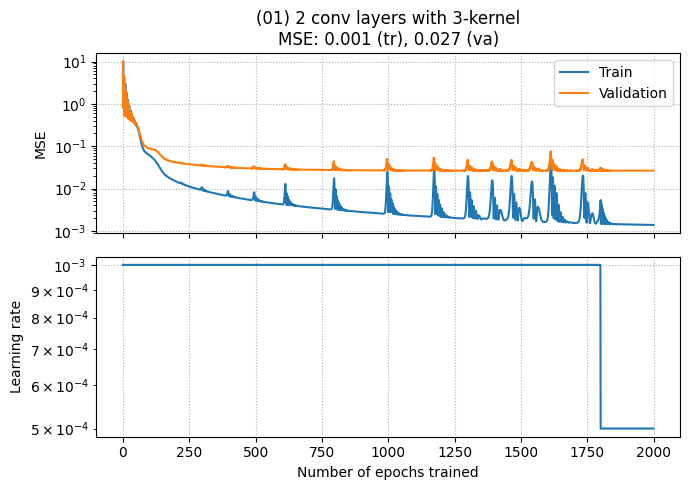

Sequential(
  (0): Conv1d(1, 4, kernel_size=(3,), stride=(1,), padding=same, padding_mode=circular)
  (1): ReLU()
  (2): Conv1d(4, 4, kernel_size=(3,), stride=(1,), padding=same, padding_mode=circular)
  (3): ReLU()
  (4): Conv1d(4, 4, kernel_size=(3,), stride=(1,), padding=same, padding_mode=circular)
  (5): ReLU()
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=34300, out_features=1, bias=True)
)


  0%|          | 0/2000 [00:00<?, ?it/s]

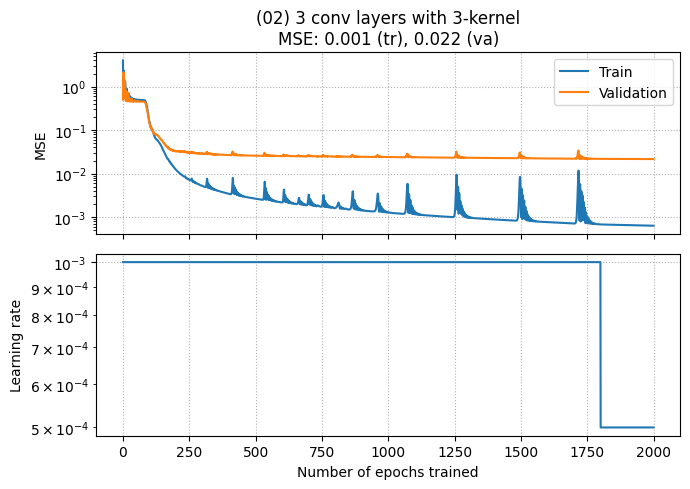

Sequential(
  (0): Conv1d(1, 4, kernel_size=(3,), stride=(1,), padding=same, padding_mode=circular)
  (1): ReLU()
  (2): Conv1d(4, 4, kernel_size=(3,), stride=(1,), padding=same, padding_mode=circular)
  (3): ReLU()
  (4): Conv1d(4, 4, kernel_size=(3,), stride=(1,), padding=same, padding_mode=circular)
  (5): ReLU()
  (6): Conv1d(4, 4, kernel_size=(3,), stride=(1,), padding=same, padding_mode=circular)
  (7): ReLU()
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=34300, out_features=1, bias=True)
)


  0%|          | 0/2000 [00:00<?, ?it/s]

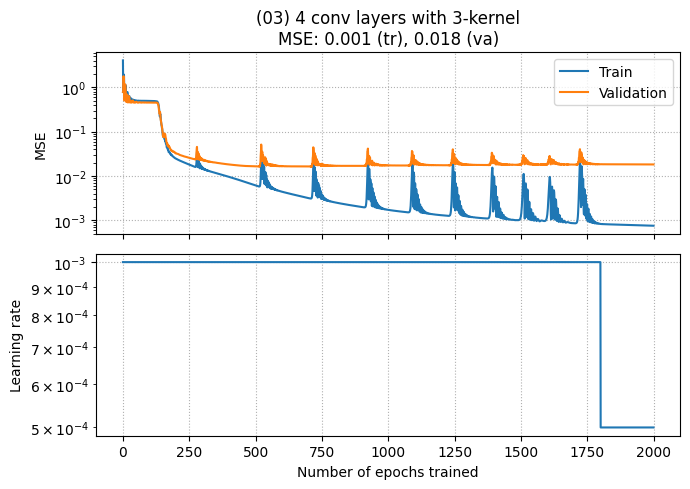

Sequential(
  (0): Conv1d(1, 4, kernel_size=(3,), stride=(1,), padding=same, padding_mode=circular)
  (1): ReLU()
  (2): Conv1d(4, 4, kernel_size=(3,), stride=(1,), padding=same, padding_mode=circular)
  (3): ReLU()
  (4): Conv1d(4, 4, kernel_size=(3,), stride=(1,), padding=same, padding_mode=circular)
  (5): ReLU()
  (6): Conv1d(4, 4, kernel_size=(3,), stride=(1,), padding=same, padding_mode=circular)
  (7): ReLU()
  (8): Conv1d(4, 4, kernel_size=(3,), stride=(1,), padding=same, padding_mode=circular)
  (9): ReLU()
  (10): Flatten(start_dim=1, end_dim=-1)
  (11): Linear(in_features=34300, out_features=1, bias=True)
)


  0%|          | 0/2000 [00:00<?, ?it/s]

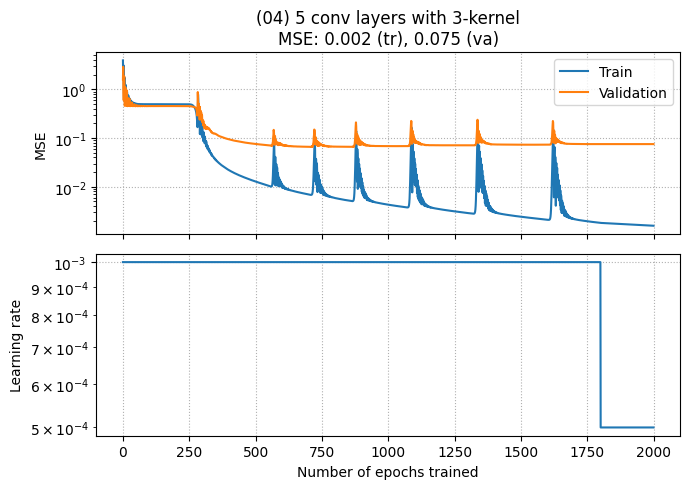

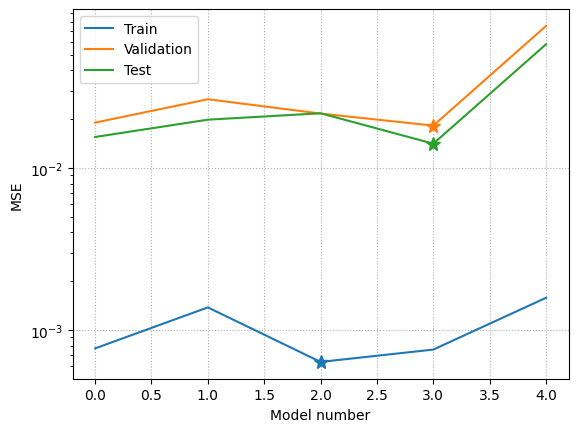

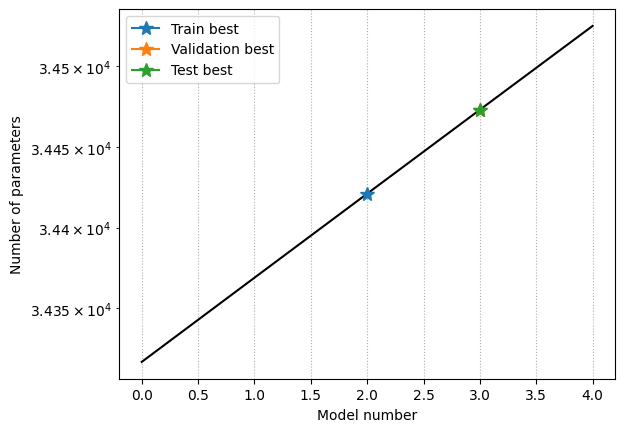

In [9]:
# note that labels need to be converted to the native byte ordering with '=f4' in order to play nice with pytorch
X_tr = torch.tensor(train_features).to(torch.float32).to(device).reshape((len(X_tr), 1, -1))
Y_tr = torch.tensor(train_labels['LOGG'].astype('=f4')).to(torch.float32).to(device)
X_va = torch.tensor(valid_features).to(torch.float32).to(device).reshape((len(X_va), 1, -1))
Y_va = torch.tensor(valid_labels['LOGG'].astype('=f4')).to(torch.float32).to(device)

m = train_features.shape[-1]  # number of features


def make_cnn(channel_sizes, mlp_sizes, activation=nn.ReLU, kernel_size=3):
    if len(channel_sizes) < 2:
        raise ValueError('channel_sizes must be at least length 2 (in, [hiddens...,] out)')
    
    layers = []
    
    # add the conv layers, interleaved with activation
    kw = dict(padding='same', padding_mode='circular')
    for i in range(len(channel_sizes) - 1):
        c1 = channel_sizes[i]
        c2 = channel_sizes[i + 1]
        layers.append(nn.Conv1d(c1, c2, kernel_size, **kw))
        layers.append(activation())
    
    # add a reshape to flatten the multi-channeled features
    layers.append(nn.Flatten())
    
    # add the MLP layers, interleaved with activation
    fc_sizes = [ channel_sizes[-1] * m ] + mlp_sizes + [1]
    for i in range(len(fc_sizes) - 1):
        m1 = fc_sizes[i]
        m2 = fc_sizes[i + 1]
        layers.append(nn.Linear(m1, m2))
        if i != len(fc_sizes) - 2:
            layers.append(activation())
    
    return nn.Sequential(*layers)


def train_cnn(layer_channels, mlp_layer_sizes=[], activation=nn.ReLU, kernel_size=3, lr=1e-3, weight_decay=0.01, n_epochs=2_000):
    net = make_cnn(layer_channels, mlp_layer_sizes, activation, kernel_size).to(device)
    print(net)
    opt = AdamW(net.parameters(), lr=lr, weight_decay=weight_decay)
    sched = torch.optim.lr_scheduler.StepLR(opt, n_epochs * 0.9, gamma=0.5)
    loss_fn = nn.MSELoss()

    history = {
        'loss_tr': [],
        'loss_va': [],
        'lr': []
    }

    for i in tqdm(range(n_epochs)):
        net.train()
        opt.zero_grad()
        Y_hat = net(X_tr).squeeze()
        loss = loss_fn(Y_hat, Y_tr)
        history['loss_tr'].append(loss.detach().cpu().item())
        loss.backward()
        opt.step()

        net.eval()
        Y_hat = net(X_va).squeeze()
        loss = loss_fn(Y_hat, Y_va)
        history['loss_va'].append(loss.detach().cpu().item())
        history['lr'].append(opt.param_groups[0]['lr'])
        sched.step()

    return net, history


from itertools import product

channel_choices = [ [1, 4], [1, 4, 4], [1, 4, 4, 4], [1, 4, 4, 4, 4], [1, 4, 4, 4, 4, 4] ]
kernel_choices = [3]
mlp_layer_choices = [ [] ]
combinations = list(product(channel_choices, kernel_choices, mlp_layer_choices))

nets = []
train_loss = []
val_loss = []

for i, (ch_choice, kernel_choice, mlp_choice) in enumerate(combinations):
    filename = f"hw3_models/conv_{i:02d}.pt"
    
    try:
        # check if we've already trained this network
        state_dict = torch.load(filename)
        net = make_cnn(layer_channels, mlp_layer_sizes, kernel_size).to(device)
        net.load_state_dict(state_dict)
        history = np.load(filename.replace('.pt', '_history.npz'))
    except OSError:
        # make and train the network ourselves
        net, history = train_cnn(ch_choice, mlp_choice, kernel_size=kernel_choice)
        torch.save(net.state_dict(), filename)
        np.savez(
            filename.replace('.pt', '_history.npz'),
            loss_tr=history['loss_tr'],
            loss_va=history['loss_va'],
            lr=history['lr']
        )

    plot_history(
        history,
        title=(
            f"({i:02d}) {len(ch_choice) - 1} conv layers with {kernel_choice}-kernel\n" +
            f"MSE: {history['loss_tr'][-1]:.3f} (tr), " +
            f"{history['loss_va'][-1]:.3f} (va)"
        )
    )
    
    net.eval()
    nets.append(net)
    train_loss.append(history['loss_tr'][-1])
    val_loss.append(history['loss_va'][-1])
    

X_te = torch.tensor(test_features).to(torch.float32).to(device).reshape((len(test_features), 1, -1))
Y_te = torch.tensor(test_labels['LOGG'].astype('=f4')).to(torch.float32).to(device)

test_loss = [nn.MSELoss()(net(X_te).squeeze(), Y_te).detach().cpu().item() for net in nets]

n_params = [ sum(p.numel() for p in net.parameters() if p.requires_grad) for net in nets ]

for i, (loss, label) in enumerate(zip([train_loss, val_loss, test_loss], ['Train', 'Validation', 'Test'])):
    xs = np.arange(len(loss))
    plt.plot(xs, loss, label=label, c=f"C{i}")
    idx = np.argmin(loss)
    plt.plot(xs[idx], loss[idx], c=f"C{i}", marker="*", markersize=10)
plt.xlabel('Model number')
plt.ylabel('MSE')
plt.yscale('log')
plt.legend()
plt.grid(ls=':')
plt.show()


xs = np.arange(len(nets))
plt.plot(xs, n_params, c=f"k")
for i, (loss, label) in enumerate(zip([train_loss, val_loss, test_loss], ['Train', 'Validation', 'Test'])):
    idx = np.argmin(loss)
    plt.plot(xs[idx], n_params[idx], c=f"C{i}", marker="*", markersize=10, label=f"{label} best")
plt.xlabel('Model number')
plt.ylabel('Number of parameters')
plt.yscale('log')
plt.legend()
plt.grid(ls=':')
plt.show()

Model summary:

| Model name | # conv | Kernel size | # linear |
| - | - | - | - |
| 00 | 1 | 3 | 1 |
| 01 | 1 | 5 | 1 |
| 02 | 2 | 3 | 1 |
| 03 | 2 | 5 | 1 |
| 04* | 3* | 3* | 1* |
| 05 | 3 | 5 | 1 |



It is encouraging to see that the best validation performance happens with the same model as the best test performance.

I did other runs where I varied the kernel size and number of linear layers, and I found that `kernel_size=3` always outperforms `kernel_size=5` on the validation and test sets, and changing the number of linear layers had little effect on anything but the training time. So, this is my last set of runs, where I'm varying just the number of convolutional layers.

In the end, we see that the best-performing models here outperform the MLPs by a little bit: final validation/test MSE is around 0.01–0.02 as opposed to the 0.03–0.04 we saw with MLPs. It's not substantial, though—same order of magnitude—and the _train_ MSE is orders of magnitude better now, so these models seem to be much more susceptible to overfitting.

The worst point (point #333) has a residual of -1.19.


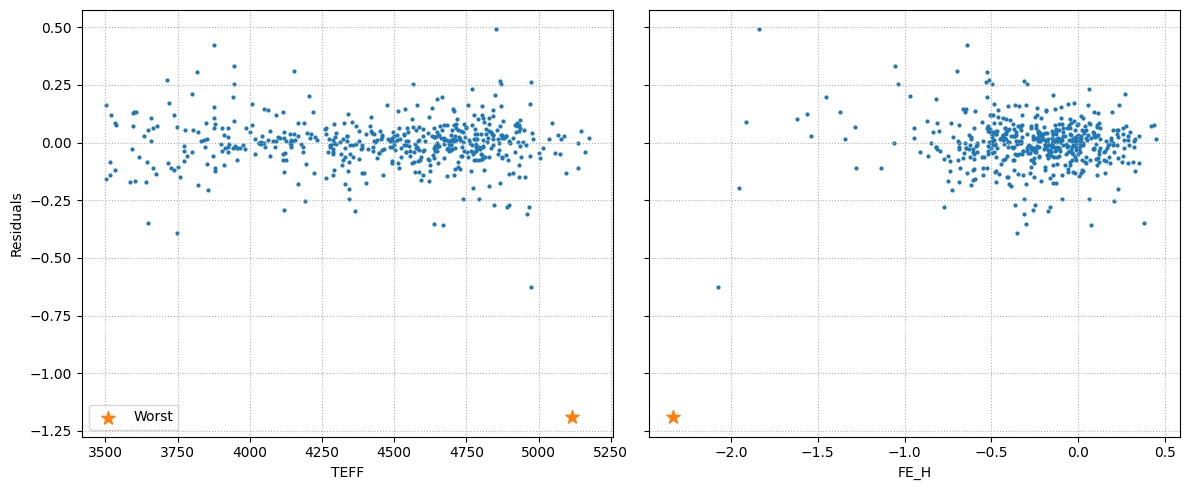

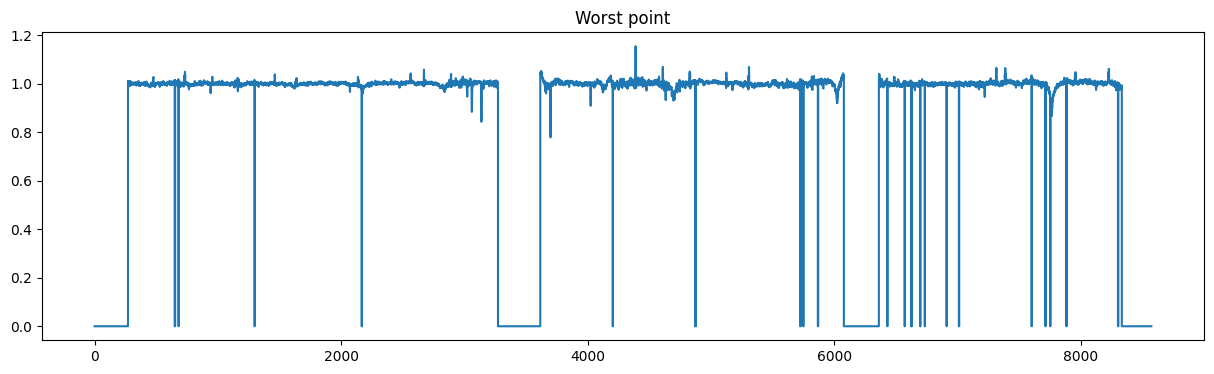

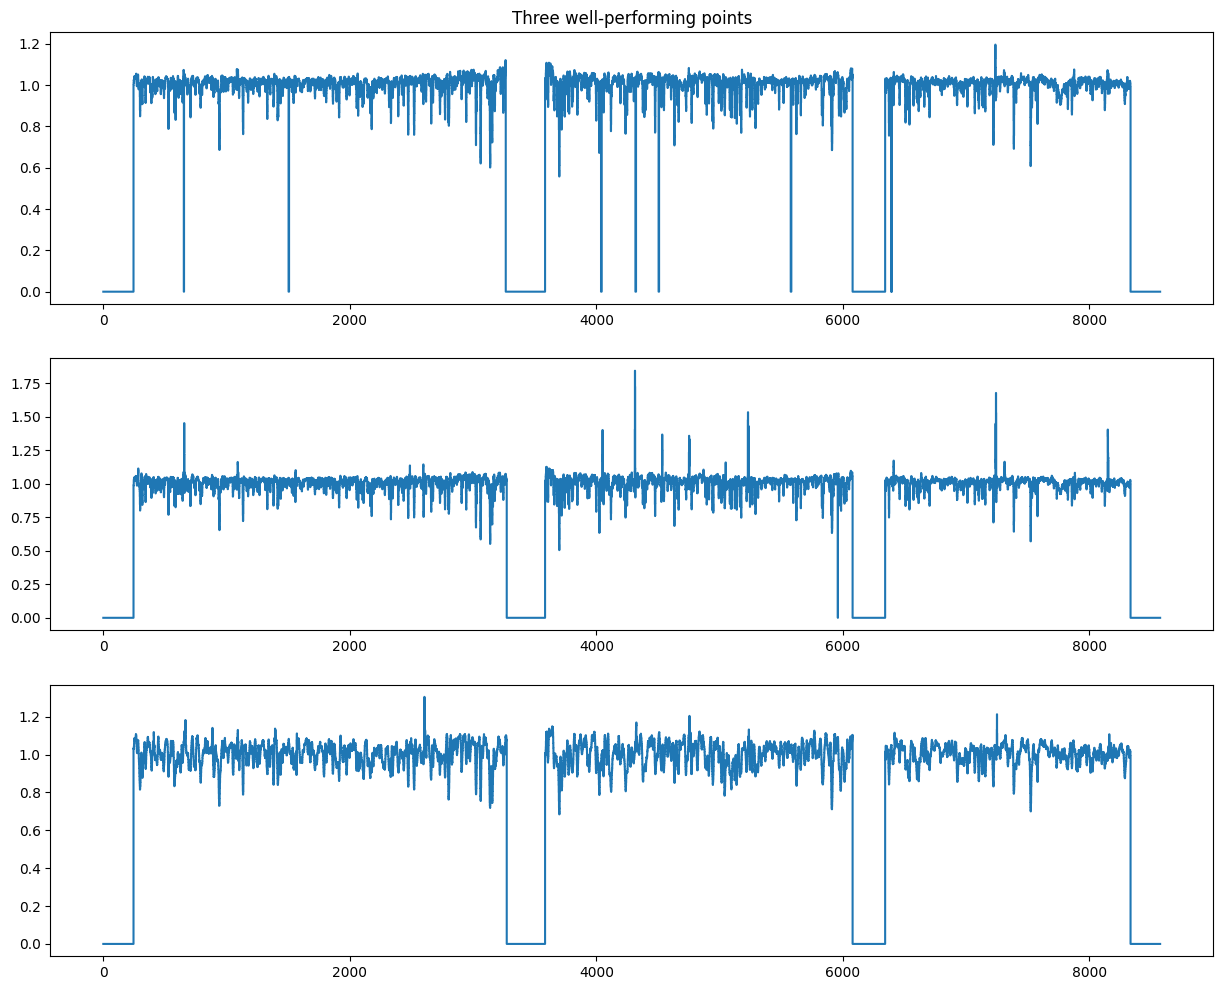

In [12]:
best_net = nets[3]
resid = (best_net(X_te).squeeze() - Y_te).detach().cpu().numpy()
worst_point = np.argmax(np.abs(resid))

print(f"The worst point (point #{worst_point}) has a residual of {resid[worst_point]:.2f}.")

teff = test_labels['TEFF']
fe_h = test_labels['FE_H']

fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
kw = dict(s=4, label='_')
worst_kw = dict(s=100, marker='*', label='Worst')
axs[0].scatter(teff, resid, **kw)
axs[0].scatter(teff[worst_point], resid[worst_point], **worst_kw)
axs[0].set_xlabel("TEFF")
axs[0].set_ylabel("Residuals")
axs[0].grid(ls=':')
axs[0].legend(loc='lower left')

axs[1].scatter(fe_h, resid, **kw)
axs[1].scatter(fe_h[worst_point], resid[worst_point], **worst_kw)
axs[1].set_xlabel("FE_H")
axs[1].grid(ls=':')

fig.tight_layout()
plt.show()

worst_features = X_te.cpu().squeeze()[worst_point]
plt.figure(figsize=(15, 4))
plt.step(np.arange(len(worst_features)), worst_features) #, s=1)
plt.title('Worst point')
plt.show()

rng = np.random.default_rng(0)
idx = rng.choice(np.arange(len(resid))[resid < 0.3], size=(3,))

fig, axs = plt.subplots(len(idx), 1, figsize=(15, 4 * len(idx)))
for i, ax in zip(idx, axs.flat):
    feats = X_te.cpu().squeeze()[i]
    ax.step(np.arange(len(feats)), feats)
axs[0].set_title('Three well-performing points')
plt.show()

Interestingly, the worst point is the same here as it was with our best MLP! And the rest of the residuals are similarly distributed as well.

## Problem 4

> Make a substantial visualization of the data you are going to use for your final project. That means showing many data examples, and scatter plots of your labels (if relevant). Try to make a visualization that gives the sense that your project might have a chance of working? If you need help, work with your buddies and come see Prof Hogg.

I will show you something on my final project soon I promise